In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from multiprocessing import Pool
sys.path.append('../Module_Analysis/')
import Pair_Corelation_Function as PCF
#import Clustering as Clust
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend')
import Gillespie_backend as backend
import Simulate_System as SimSys
sys.path.append('/home/hcleroy/Extra_Module_py/')
import formated_matplotlib

## On the emergence of multiple clusters
In this notebook, we investigate whether multiple cluster can form throughout the equilibration. It seems that the higher is the binding energy, the less ergodic the system become. Notice that longer polymer requires larger binding energy to reach the same state. We still have to find a "good" definition of clustering, in order to clearly make this point. If we can characterize the clustering in few parameters, we will be able to systematically test their value for a range of binding energy. Notice that I just used the number of timestep to asses the time of equilibration. Which should be converted in real time.

In [118]:
# define the unit of the system :
dimension = 3

L = 1000
NLinker = 20

Eb = -30.

kdiff = 0.000207352*5

seed = np.random.randint(0,1000000)

In [119]:
Sys = backend.Gillespie(  ell_tot=L,
                    rho0=0.,
                    BindingEnergy=Eb,
                    kdiff=kdiff,
                    seed = seed,
                    Nlinker=NLinker,dimension=dimension) 

In [120]:
Sys.evolve(10**6)

(array([1, 1, 1, ..., 0, 3, 0]),
 array([1.16499527e+02, 2.80297013e+01, 4.97725273e+00, ...,
        2.04334348e+11, 4.83335287e+00, 5.11849932e+10]))

(<Figure size 334.646x251.613 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

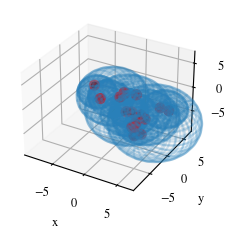

In [121]:
Sys.Plot3DGillespie()

# Clustering methods

In [122]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
def split_data_per_cluster(kmeans,data):
    """
    Given a kmeans object that we used to split the data into clusters.
    The data are then splitted according to the cluster where the belong.
    """
    data_out = []
    for i in range(kmeans.n_clusters):   
        kmeans.labels_
        data_out.append(data[np.argwhere(kmeans.labels_==i)[:,0]])
    return data_out
def compute_dist_vector(array):
    """
    return a 1D vector of distance between the points in the array.
    The shape of the array must be Nx3, where N is the number of points
    """
    if array.shape[0]==1:
        # return an unique 0 to allow the computation of the mean
        return np.array([0.])
    dists = np.zeros(array.shape[0]*(array.shape[0]-1)//2,dtype=float)
    k=0
    for i in range(array.shape[0]):
        for j in range(i):
            dists[k] = np.linalg.norm(array[i]-array[j])
            k+=1
    return dists
def compute_mutual_distance(A1,A2):
    """
    return a 1D vector of distance between the two arrays.
    """
    dists = np.zeros(A1.shape[0]*A2.shape[0],dtype=float)
    k=0
    for a1 in A1:
        for a2 in A2:
            dists[k] = np.linalg.norm(a1-a2)
            k+=1
    return dists

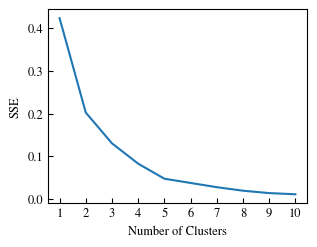

4


In [123]:
# find the correct number of cluster:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Sys.get_R())
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), np.array(sse)/sum(sse))
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(kl.elbow)

In [124]:
nc = kl.elbow
kmeans = KMeans(n_clusters=nc)
kmeans.fit(Sys.get_R())

KMeans(n_clusters=4)

In [125]:
data_splitted = split_data_per_cluster(kmeans,Sys.get_R())

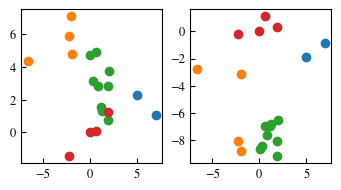

In [126]:
fig,ax = plt.subplots(ncols=2,figsize=(4,2))
for i in range(data_splitted.__len__()):
    ax[0].scatter(data_splitted[i][:,0],data_splitted[i][:,1])
    ax[1].scatter(data_splitted[i][:,0],data_splitted[i][:,2])

In [106]:
for i in range(data_splitted.__len__()):
    print("average distance between points in the cluster "+str(i)+" = "+str(np.mean(compute_dist_vector(data_splitted[i]))))
print()
for i in range(data_splitted.__len__()):
    for j in range(i+1,data_splitted.__len__()):
        print("average distance between the clusters "+str(i)+" and the cluster "+str(j)+" = "+str(np.mean(compute_mutual_distance(data_splitted[i],data_splitted[j]))))

average distance between points in the cluster 0 = 3.611947668501682
average distance between points in the cluster 1 = 5.070566165343265
average distance between points in the cluster 2 = 1.4332776543074714

average distance between the clusters 0 and the cluster 1 = 8.574333441837009
average distance between the clusters 0 and the cluster 2 = 5.701589559444637
average distance between the clusters 1 and the cluster 2 = 9.875378744619894


In [127]:
for i in range(data_splitted.__len__()):
    print("average distance between points in the cluster "+str(i)+" = "+str(np.mean(compute_dist_vector(data_splitted[i]))))
print()
for i in range(data_splitted.__len__()):
    for j in range(i+1,data_splitted.__len__()):
        print("average distance between the clusters "+str(i)+" and the cluster "+str(j)+" = "+str(np.mean(compute_mutual_distance(data_splitted[i],data_splitted[j]))))

average distance between points in the cluster 0 = 2.524542520159679
average distance between points in the cluster 1 = 5.394721072914151
average distance between points in the cluster 2 = 2.509447876588251
average distance between points in the cluster 3 = 2.7660687396264687

average distance between the clusters 0 and the cluster 1 = 11.319546412336845
average distance between the clusters 0 and the cluster 2 = 8.235754993545315
average distance between the clusters 0 and the cluster 3 = 6.562129821044596
average distance between the clusters 1 and the cluster 2 = 6.411175080657912
average distance between the clusters 1 and the cluster 3 = 9.463201942606705
average distance between the clusters 2 and the cluster 3 = 8.892038019125946


In [139]:
def dummy(**kwargs):
    try:
        print(kwargs['aight'])
    except KeyError:
        

In [141]:
dummy(aigt=2)

KeyError: 'aight'